In [2]:
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

In [3]:
dataset_path = './dataset'
samples = 25

In [4]:
# Helper function to plot the images in a grid

def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize = (10,5), rows = 1, titles = None, maintitle = None):
    f = plt.figure(figsize = figsize)
    if maintitle is not None: 
        plt.suptitle(maintitle, fontsize = 10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: 
            sp.set_title(titles[i], fontsize = 16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [5]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

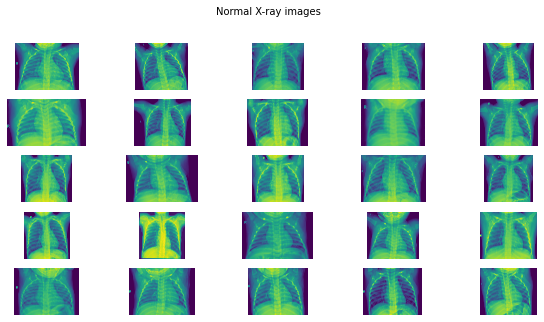

In [6]:
plots_from_files(normal_images, rows = 5, maintitle = "Normal X-ray images")

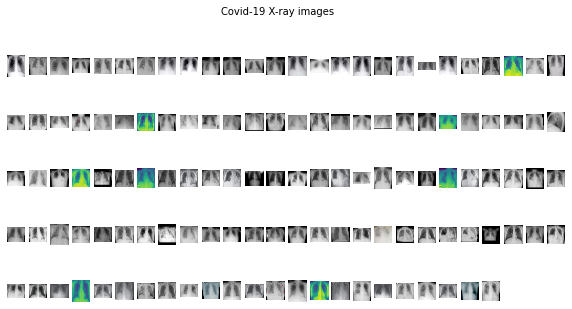

In [7]:
plots_from_files(covid_images, rows = 5, maintitle = "Covid-19 X-ray images")

## Data preprocessing

In [8]:
INIT_LR = 1e-3
EPOCHS = 15
BS = 25

In [9]:
print("[INFO] loading images...")

imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [10]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# split train and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.20, stratify = labels, random_state = 42)

# data augmentation 
trainAug = ImageDataGenerator(rotation_range = 15, fill_mode = "nearest")

## Model

In [11]:
# load the VGG16 model with imagenet weights 
baseModel = VGG16(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (4, 4))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(64, activation = "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = "softmax")(headModel)
model = Model(inputs = baseModel.input, outputs = headModel)

for layer in baseModel.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


### Training

In [12]:
print("[INFO] compiling model...")
opt = Adam(learning_rate = INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

print("[INFO] training head...")
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data = (testX, testY),
    validation_steps = len(testX) // BS,
    epochs = EPOCHS
    )

[INFO] compiling model...
[INFO] training head...
Epoch 1/15
4/4 [==============================] - 24s 2s/step - loss: 0.7848 - accuracy: 0.4700 - val_loss: 0.5764 - val_accuracy: 0.8387
Epoch 2/15
4/4 [==============================] - 3s 290ms/step - loss: 0.5250 - accuracy: 0.8646 - val_loss: 0.4723 - val_accuracy: 0.8387
Epoch 3/15
4/4 [==============================] - 1s 344ms/step - loss: 0.4880 - accuracy: 0.8542 - val_loss: 0.4467 - val_accuracy: 0.8387
Epoch 4/15
4/4 [==============================] - 1s 326ms/step - loss: 0.4877 - accuracy: 0.8438 - val_loss: 0.4438 - val_accuracy: 0.8387
Epoch 5/15
4/4 [==============================] - 1s 380ms/step - loss: 0.4045 - accuracy: 0.8542 - val_loss: 0.4435 - val_accuracy: 0.8387
Epoch 6/15
4/4 [==============================] - 1s 321ms/step - loss: 0.5120 - accuracy: 0.8125 - val_loss: 0.4412 - val_accuracy: 0.8387
Epoch 7/15
4/4 [==============================] - 2s 380ms/step - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.

### Plot training metrics

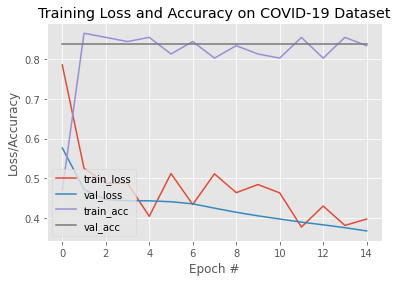

In [13]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label = "val_acc")

plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

### Evaluation

In [14]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size = BS)
predIdxs = np.argmax(predIdxs, axis = 1)
print(classification_report(testY.argmax(axis = 1), predIdxs, target_names = lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.84      1.00      0.91        26
      normal       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Saving Model

In [15]:
# Save the entire model to a HDF5 file.
model.save('covid_model.h5') 

### Testing Loaded Model


In [16]:
from tensorflow.keras.models import load_model

new_model = load_model('covid_model.h5')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
print("[INFO] evaluating network...")
predIdxs = new_model.predict(testX, batch_size = BS)
predIdxs = np.argmax(predIdxs, axis = 1)
print(classification_report(testY.argmax(axis = 1), predIdxs, target_names = lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.84      1.00      0.91        26
      normal       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image

[[0.99233454 0.00766542]]
[0]


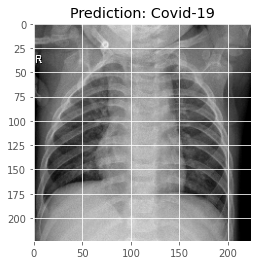

In [21]:
# Test on Normal Image

img_width, img_height = 224, 224
img = image.load_img(r'dataset/normal/IM-0511-0001-0001.jpeg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

# label with corresponding largest predicted probability
pred = new_model.predict(img)
print(pred)
print(np.argmax(pred, axis = 1))

if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')

plt.imshow(x/255.)

[[1.0000000e+00 8.5872366e-21]]
0


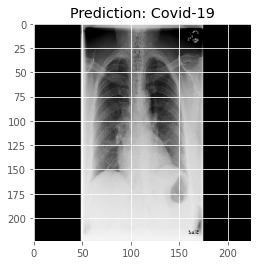

In [20]:
# Test on Covid Image

img_width, img_height = 224, 224
img = image.load_img(r'dataset/covid-yes.jpg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

# label with corresponding largest predicted probability
pred = new_model.predict(img)
print(pred)
print(np.argmax(pred, axis=1)[0])

if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)